# Import libraries

In [1]:
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import time
import cv2
import pickle
from tqdm import tqdm
from matplotlib import pyplot as plt
import mediapipe as mp
import tensorflow as tf
from tensorflow.data import AUTOTUNE
from collections import Counter

2022-05-24 12:07:29.086186: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [3]:
ROUND = 1
SEQ_LEN = 16
EXERCISE = 'squat'
CUR_CLASS = 'up'
PREV_CLASS = 'down'
SUBFIX_VID_NAME = '_hard_vote'
REMOTE = True

# Initialize Mediapipe objects

In [4]:
mp_pose = mp.solutions.pose
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

# Load the data from disk

In [5]:
all_file_paths = []
vid_to_seqs = {}

In [6]:
if REMOTE:
    walk_path = f'/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_{SEQ_LEN}/{EXERCISE}'
else:
    walk_path = f'D:\EzFit_dataset\keypoints_seq\len_{SEQ_LEN}\{EXERCISE}'
for path, subdirs, files in tqdm(os.walk(walk_path)):
    # print(path, subdirs, files)
    if files:
        split = path.split(os.path.sep)
        vid_name = os.path.join(split[-2], split[-1]) # pushup-up/10_1
        sub_arr = []
        for file_name in files:
            if file_name.endswith('.npy'):
                full_path = os.path.join(path, file_name)
                all_file_paths.append(full_path)
                sub_arr.append(full_path)
        vid_to_seqs[vid_name] = sub_arr

485it [00:00, 17614.12it/s]


In [7]:
# vid_to_seqs

In [8]:
# all_file_paths

In [9]:
# use to check the balance of data and fit LabelEncoder
labels = list(map(lambda x: x.split(os.path.sep)[-3], all_file_paths))
labels

['squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-down',
 'squat-do

In [10]:
# all data
Counter(labels)

Counter({'squat-down': 3327, 'squat-up': 2683, 'idle': 3327, 'others': 2820})

In [11]:
# will be use for class weighting later
# total = len(labels)
# label_count = Counter(labels)
# label_count, total

In [12]:
def load_numpy(path):
    return np.load(path.numpy())

In [13]:
def load_data(file_path):
    # load numpy, file_path is Tensor with dtype string
    # and np.load not working with Tensor, so we need to work around with pure tf ops
    # this function return a list with elements following Tout, 
    # so we need to access first item
    data = tf.py_function(load_numpy, inp=[file_path], Tout=[tf.float32])[0] # return as tensor with dtype tf.float32

    # get label
    label_str = tf.strings.split(file_path, os.path.sep)[-3]
    one_hot = label_str == le.classes_ # get tensor with dtype bool
    label = tf.cast(one_hot, tf.int32)
    return data, label

# Preprocess Data

In [14]:
le = LabelEncoder()
le.fit(labels)
le.classes_

array(['idle', 'others', 'squat-down', 'squat-up'], dtype='<U10')

In [15]:
labels = le.transform(labels)
labels

array([2, 2, 2, ..., 1, 1, 1])

### Split video-level splitting

In [16]:
# split_vids = list(vid_to_seqs.keys())
# split_vids

In [15]:
# split_vids_class = list(map(lambda x: x.split('/')[0], split_vids))

In [19]:
# split vid level balanceness
# Counter(split_vids_class)

Counter({'squat-down': 122, 'squat-up': 123, 'idle': 122, 'others': 122})

In [20]:
# check correctness
# len(split_vids), len(np.unique(split_vids))

(489, 489)

In [21]:
# train_vids, test_vids = train_test_split(split_vids, test_size=0.1, random_state=42, stratify=split_vids_class)

In [22]:
# len(train_vids), len(test_vids)

(440, 49)

In [23]:
# check stratify
# Counter(list(map(lambda x: x.split('/')[0], test_vids)))

Counter({'idle': 12, 'squat-down': 12, 'others': 12, 'squat-up': 13})

In [16]:
# map train_vids/test_vids to their corresponding paths
def vid_to_seq_level(vids_list, vid_seq_mapping):
    for i in range(len(vids_list)):
        if i == 0: # first iteration
            result = vid_seq_mapping[vids_list[i]].copy()
        else:
            result.extend(vid_seq_mapping[vids_list[i]])
    return result

In [25]:
# train_paths = vid_to_seq_level(train_vids, vid_to_seqs)
# test_paths = vid_to_seq_level(test_vids, vid_to_seqs)

In [26]:
# train_paths

['/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/squat/squat-down/23_6/23_6_20.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/squat/squat-down/23_6/23_6_18.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/squat/squat-down/23_6/23_6_36.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/squat/squat-down/23_6/23_6_35.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/squat/squat-down/23_6/23_6_52.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/squat/squat-down/23_6/23_6_33.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/squat/squat-down/23_6/23_6_17.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/squat/squat-down/23_6/23_6_25.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/squat/squat-down/23_6/23_6_12.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/keypoints_seq/len_8/squat/squat-down/23_6/23_6_37.npy',
 '/home/u6

In [27]:
# len(train_paths), len(test_paths)

(13589, 1851)

In [28]:
# # will be use for class weighting later
# labels = list(map(lambda x: x.split(os.path.sep)[-3], train_paths))
# total = len(labels)
# label_count = Counter(labels)
# label_count, total

(Counter({'squat-down': 3808, 'idle': 3803, 'others': 2760, 'squat-up': 3218}),
 13589)

### Sequence-level splitting

In [16]:
train_paths, test_paths = train_test_split(all_file_paths, test_size=0.1, random_state=42, stratify=labels)

In [17]:
len(train_paths), len(test_paths)

(10941, 1216)

In [18]:
# will be use for class weighting later
labels = list(map(lambda x: x.split(os.path.sep)[-3], train_paths))
total = len(labels)
label_count = Counter(labels)
label_count, total

(Counter({'squat-up': 2415, 'others': 2538, 'idle': 2994, 'squat-down': 2994}),
 10941)

# Training prep

In [19]:
def build_model():
    model = tf.keras.models.Sequential([
        # ลด lstm จำนวน unit 64
        tf.keras.layers.LSTM(64, return_sequences=False, activation='relu', input_shape=(SEQ_LEN, 99)),
    #     tf.keras.layers.LSTM(128, return_sequences=True, activation='relu'),
    #     tf.keras.layers.LSTM(64, return_sequences=False, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

In [20]:
# define hyperparameters
EPOCHS = 150
BATCH_SIZE = 32
NUM_CLASSES = len(le.classes_)
INIT_LR = 1e-3

---

# Cross-validation training

In [22]:
## From AJ Mock
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

split_vids = np.array(split_vids)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold = {'train_loss': [], 'val_loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

all_y_hat_test = []
all_y_test = []
for f_idx, (train_index, test_index) in enumerate(skf.split(split_vids, split_vids_class)):
    print(f'-= [Fold {f_idx}] =-')
    train_vids, test_vids = split_vids[train_index], split_vids[test_index]
    
    train_paths = vid_to_seq_level(train_vids, vid_to_seqs)
    test_paths = vid_to_seq_level(test_vids, vid_to_seqs)
    
    total = len(train_paths)
    label_count = Counter(list(map(lambda x: x.split(os.path.sep)[-3], train_paths)))
    
    print(f'Train vid amount: {len(train_vids)} | Test vid amount: {len(test_vids)}')
    print(f'Train seq amount: {len(train_paths)} | Test seq amount: {len(test_paths)}')
    print(f'Train seq label count: {dict(sorted(label_count.items()))}')
    print(f'Test seq label count: {dict(sorted(Counter(list(map(lambda x: x.split(os.path.sep)[-3], test_paths))).items()))}')
    
    # class weighting
    NUM_CLASSES = len(le.classes_)
    class_weights = {}
    for label in label_count:
        class_weights[le.transform([label])[0]] = (1 / label_count[label]) * (total / NUM_CLASSES)
    print('Classes:', le.classes_)
    print('Class weights:', dict(sorted(class_weights.items())))
        
    train_ds = tf.data.Dataset.from_tensor_slices(train_paths)
    train_ds = (train_ds
                .shuffle(len(train_paths), seed=42)
                .map(load_data, num_parallel_calls=AUTOTUNE)
                .cache()
                .batch(BATCH_SIZE)
                .prefetch(AUTOTUNE)
               )
    
    test_ds = tf.data.Dataset.from_tensor_slices(test_paths)
    test_ds = (test_ds
                .map(load_data, num_parallel_calls=AUTOTUNE)
                .cache()
                .batch(BATCH_SIZE)
                .prefetch(AUTOTUNE)
               )
    
    model = build_model()
    log_dir = os.path.join('Logs')
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    hist = model.fit(train_ds, 
          validation_data=test_ds, 
          epochs=EPOCHS, 
          callbacks=[early_stopping, tb_callback],
          class_weight=class_weights)
    
    y_hat_test_probs = model.predict(test_ds)
    y_hat_test = np.argmax(y_hat_test_probs, axis=1)
    raw_y_test = np.concatenate([y for x, y in test_ds], axis=0)
    y_test = np.argmax(raw_y_test, axis=1)
    
    print(f'Test Accuracy: {accuracy_score(y_true=y_test, y_pred=y_hat_test):.2f}')
    print(f'Test Macro F1-score: {f1_score(y_true=y_test, y_pred=y_hat_test, average="macro"):.2f}')
    
    fold['train_loss'].append(hist.history['loss'][-15])
    fold['val_loss'].append(hist.history['val_loss'][-15])
    fold['accuracy'].append(accuracy_score(y_true=y_test, y_pred=y_hat_test))
    fold['precision'].append(precision_score(y_true=y_test, y_pred=y_hat_test, average='macro'))
    fold['recall'].append(recall_score(y_true=y_test, y_pred=y_hat_test, average='macro'))
    fold['f1'].append(f1_score(y_true=y_test, y_pred=y_hat_test, average='macro'))
    
    all_y_hat_test.append(y_hat_test)
    all_y_test.append(y_test)
    
all_y_hat_test = np.vstack(all_y_hat_test)
all_y_test = np.vstack(all_y_test)

NameError: name 'split_vids' is not defined

In [68]:
save_cv = f'saved_artifacts/cv_result/len_{SEQ_LEN}/round_{ROUND}/{EXERCISE}'
if not os.path.exists(save_cv):
    os.makedirs(save_cv, exist_ok=True)
with open(os.path.join(save_cv,f'{EXERCISE}_kps_seq_cv.pickle'), 'wb') as file:
    pickle.dump(fold, file)

In [69]:
# avg cv
fold

{'train_loss': [0.5755961537361145,
  0.2991354465484619,
  0.38023537397384644,
  0.3500932455062866,
  0.3323803246021271,
  0.25822094082832336,
  0.22903253138065338,
  0.417510449886322,
  0.1977362334728241,
  0.408559113740921],
 'val_loss': [0.9740620255470276,
  0.4259565472602844,
  0.468708872795105,
  0.6667155027389526,
  1.0760188102722168,
  1.2720816135406494,
  1.4981669187545776,
  0.5732372999191284,
  0.4483863413333893,
  1.3011795282363892],
 'accuracy': [0.5752753977968176,
  0.9009009009009009,
  0.8355795148247979,
  0.7520325203252033,
  0.8719851576994434,
  0.712707182320442,
  0.6927860696517413,
  0.8461538461538461,
  0.9180035650623886,
  0.6611675126903553],
 'precision': [0.5718178047209207,
  0.882798680463461,
  0.7993517953643201,
  0.6892821295255289,
  0.8509920634920636,
  0.7419217522728678,
  0.6162091982208939,
  0.7933465795859209,
  0.9027062145976154,
  0.6845026115859449],
 'recall': [0.5376605359826435,
  0.8756083075787628,
  0.803973169

---

# Normal training

## Class weighting
Since we have a bit imbalanced data, so we should do class weighting  
formula derived from here: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#calculate_class_weights

In [21]:
NUM_CLASSES = len(le.classes_)
class_weights = {}
for label in label_count:
    class_weights[le.transform([label])[0]] = (1 / label_count[label]) * (total / NUM_CLASSES)

In [22]:
label_count

Counter({'squat-up': 2415, 'others': 2538, 'idle': 2994, 'squat-down': 2994})

In [23]:
le.classes_

array(['idle', 'others', 'squat-down', 'squat-up'], dtype='<U10')

In [24]:
class_weights

{3: 1.132608695652174,
 1: 1.0777186761229316,
 0: 0.9135771543086173,
 2: 0.9135771543086173}

## Build data pipeline

In [25]:
train_ds = tf.data.Dataset.from_tensor_slices(train_paths)
train_ds = (train_ds
            .shuffle(len(train_paths), seed=42)
            .map(load_data, num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE)
           )

2022-05-24 11:25:22.887301: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-05-24 11:25:22.963099: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 11:25:22.963636: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.845GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 462.00GiB/s
2022-05-24 11:25:22.963650: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-05-24 11:25:22.964994: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-05-24 11:25:22.965018: I tensorflow/stream_executor/plat

In [26]:
test_ds = tf.data.Dataset.from_tensor_slices(test_paths)
test_ds = (test_ds
            .map(load_data, num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE)
           )

In [27]:
# check the shape and dtype
next(iter(train_ds))

2022-05-24 11:25:23.483110: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-24 11:25:23.484243: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3500105000 Hz
2022-05-24 11:25:23.554929: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(<tf.Tensor: shape=(32, 16, 99), dtype=float32, numpy=
 array([[[0.24715596, 0.6956255 , 0.9998723 , ..., 0.4324528 ,
          0.15042332, 0.89949673],
         [0.24747244, 0.6946744 , 0.99985236, ..., 0.44228488,
          0.15083037, 0.9042659 ],
         [0.24841963, 0.6946319 , 0.9998231 , ..., 0.45472112,
          0.1478734 , 0.9100456 ],
         ...,
         [0.25115833, 0.6966228 , 0.99937266, ..., 0.63121724,
          0.1857248 , 0.94765913],
         [0.2514122 , 0.69790095, 0.99937135, ..., 0.64597523,
          0.19503085, 0.9502286 ],
         [0.25167188, 0.69810194, 0.99932903, ..., 0.6602778 ,
          0.20672564, 0.9519722 ]],
 
        [[0.41949242, 0.22664505, 0.9997751 , ..., 0.47286534,
          0.84190947, 0.6504118 ],
         [0.42103204, 0.2176515 , 0.99972135, ..., 0.47305712,
          0.828008  , 0.6410432 ],
         [0.4221519 , 0.20164213, 0.9996959 , ..., 0.47316146,
          0.8147695 , 0.631317  ],
         ...,
         [0.43790928, 0.15182556

## Build and Train LSTM Model

In [28]:
# define callback (tensorboard)
log_dir = os.path.join('Logs')
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

2022-05-24 11:25:24.513129: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-05-24 11:25:24.513165: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-05-24 11:25:24.513203: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1611] Profiler found 1 GPUs
2022-05-24 11:25:24.513701: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda/extras/CUPTI/lib64
2022-05-24 11:25:24.514316: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcupti.so
2022-05-24 11:25:24.619483: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-05-24 11:25:24.619607: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


In [29]:
# อาจจะปรับ fps ของ input วิดีโอได้ ให้ realistic กับที่ใช้จริง

In [30]:
# build model
model = build_model()

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                41984     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
Total params: 48,820
Trainable params: 48,820
Non-trainable params: 0
_________________________________________________________________


In [32]:
optimizer = tf.keras.optimizers.Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)

In [33]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
model.fit(train_ds, 
          validation_data=test_ds, 
          epochs=EPOCHS, 
          callbacks=[early_stopping, tb_callback],
          class_weight=class_weights)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/150


2022-05-24 11:25:28.346713: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


  1/342 [..............................] - ETA: 5:22 - loss: 1.4575 - accuracy: 0.2812

2022-05-24 11:25:28.658639: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-05-24 11:25:28.746349: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-05-24 11:25:28.746366: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


  3/342 [..............................] - ETA: 1:18 - loss: 1.3882 - accuracy: 0.3750

2022-05-24 11:25:28.945015: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-05-24 11:25:28.945690: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2022-05-24 11:25:28.979211: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 1132 callback api events and 1129 activity events. 
2022-05-24 11:25:29.002862: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-05-24 11:25:29.041971: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/profile/2022_05_24_11_25_29
2022-05-24 11:25:29.072748: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to Logs/train/plugins/profile/2022_05_24_11_25_29/jarvis.trace.json.gz
2022-05-24 11:25:29.111460: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/p

342/342 [==============================] - 9s 24ms/step - loss: 0.8297 - accuracy: 0.6445 - val_loss: 0.5843 - val_accuracy: 0.7903
Epoch 2/150
342/342 [==============================] - 5s 16ms/step - loss: 0.4963 - accuracy: 0.8165 - val_loss: 0.3969 - val_accuracy: 0.8528
Epoch 3/150
342/342 [==============================] - 5s 16ms/step - loss: 0.3950 - accuracy: 0.8581 - val_loss: 0.3698 - val_accuracy: 0.8865
Epoch 4/150
342/342 [==============================] - 6s 16ms/step - loss: 0.3342 - accuracy: 0.8820 - val_loss: 0.2637 - val_accuracy: 0.9186
Epoch 5/150
342/342 [==============================] - 6s 16ms/step - loss: 0.3024 - accuracy: 0.8936 - val_loss: 0.2805 - val_accuracy: 0.9104
Epoch 6/150
342/342 [==============================] - 6s 16ms/step - loss: 0.2850 - accuracy: 0.9025 - val_loss: 0.2207 - val_accuracy: 0.9326
Epoch 7/150
342/342 [==============================] - 5s 16ms/step - loss: 0.2617 - accuracy: 0.9108 - val_loss: 0.2143 - val_accuracy: 0.9350
Epoc

---

# Setup all dirs

In [35]:
import os

In [36]:
all_dirs = []
model_dir = f'saved_models/len_{SEQ_LEN}/round_{ROUND}/{EXERCISE}/'
all_dirs.append(model_dir)
pickle_dir = f'saved_pickles/len_{SEQ_LEN}/round_{ROUND}/{EXERCISE}/'
all_dirs.append(pickle_dir)
output_vid_dir = f'output_videos/len_{SEQ_LEN}/round_{ROUND}/{EXERCISE}/'
all_dirs.append(output_vid_dir)

In [37]:
for d in all_dirs:
    if not os.path.exists(d):
        os.makedirs(d, exist_ok=True)

# Save model

In [38]:
model.save(f'saved_models/len_{SEQ_LEN}/round_{ROUND}/{EXERCISE}/{EXERCISE}_kps_seq.h5', save_format='h5')

In [39]:
# serialize lb
with open(f'saved_pickles/len_{SEQ_LEN}/round_{ROUND}/{EXERCISE}/{EXERCISE}_kps_seq_le.pickle', 'wb') as file:
    pickle.dump(le, file)

In [40]:
# command to run tensorboard
# first, going logs directory then,
# tensorboard --logdir=.

# Evaluation

In [41]:
raw_preds_y = model.predict(test_ds)
preds_y = np.argmax(raw_preds_y, axis=1)
preds_y

array([1, 2, 1, ..., 2, 3, 0])

In [42]:
# get y label back from tf.data
raw_test_y = np.concatenate([y for x, y in test_ds], axis=0)
test_y = np.argmax(raw_test_y, axis=1)
test_y

array([1, 2, 1, ..., 2, 3, 0])

In [43]:
test_y_text = le.inverse_transform(test_y)
preds_y_text = le.inverse_transform(preds_y)

### Accuracy

In [44]:
# better result with weight decay and patience = 7
_, acc = model.evaluate(test_ds)
print('Test accuracy:', acc)

38/38 [==============================] - 0s 4ms/step - loss: 0.0285 - accuracy: 0.9885
Test accuracy: 0.9884868264198303


### Confusion Matrix

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [46]:
cm = confusion_matrix(test_y_text, preds_y_text, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)

In [47]:
save_cm = f'saved_artifacts/conf_matrix/len_{SEQ_LEN}/round_{ROUND}/{EXERCISE}'
if not os.path.exists(save_cm):
    os.makedirs(save_cm, exist_ok=True)

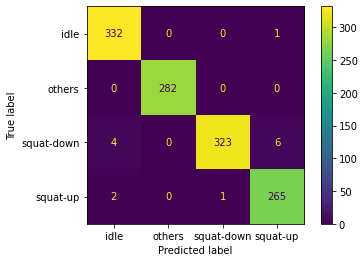

In [48]:
disp.plot()
plt.savefig(os.path.join(save_cm, 'kps_seq_cm.png'), dpi=300)
plt.show()

### ROC AUC

In [49]:
from sklearn.metrics import roc_auc_score

In [50]:
roc_auc_score(raw_test_y, raw_preds_y)

0.9996907224220974

# Detect in realtime

In [5]:
loaded_model = tf.keras.models.load_model(f'saved_models/len_{SEQ_LEN}/round_{ROUND}/{EXERCISE}/{EXERCISE}_kps_seq.h5')

2022-05-24 12:07:42.658132: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-05-24 12:07:42.731301: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 12:07:42.731825: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.845GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 462.00GiB/s
2022-05-24 12:07:42.731840: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-05-24 12:07:42.733220: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-05-24 12:07:42.733243: I tensorflow/stream_executor/plat

In [6]:
loaded_model.inputs

[<KerasTensor: shape=(None, 16, 99) dtype=float32 (created by layer 'lstm_input')>]

In [7]:
loaded_model.outputs

[<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'dense_3')>]

In [8]:
# load le
with open(f'saved_pickles/len_{SEQ_LEN}/round_{ROUND}/{EXERCISE}/{EXERCISE}_kps_seq_le.pickle', 'rb') as file:
    loaded_le = pickle.load(file)

In [9]:
from collections import deque, Counter

In [ ]:
NUM_TEST_VIDS = 3
for i in range(1,1+NUM_TEST_VIDS):
    kps_seq = deque(maxlen=SEQ_LEN)
    preds_window = deque(maxlen=15)
    rep_count = 0
    current_stage = None
    previous_stage = None
    cap = cv2.VideoCapture(f'objective_test_videos/{EXERCISE}/{EXERCISE}_{i}.mp4')
    video_size = (640, 360) # original is (1920, 1080)
    video_writer = cv2.VideoWriter(f'output_videos/len_{SEQ_LEN}/round_{ROUND}/{EXERCISE}/{EXERCISE}_{i}_kps_seq{SUBFIX_VID_NAME}.avi', cv2.VideoWriter_fourcc(*'MJPG'),
                                   25, video_size)

    with mp_pose.Pose(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as pose:
        while cap.isOpened():
            success, frame = cap.read()
            if not success:
                break

            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            image = cv2.resize(image, (640, 360))

            image.flags.writeable = False

            results = pose.process(image)

            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # Pose Detections
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, 
                                     mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                     mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                     )

            # append face&body coordinates for each frame to the csv file to create dataset to train the model
            try:
                # extract pose
                pose_coor = results.pose_landmarks.landmark
                pose_row = np.array([[landmark.x, landmark.y, landmark.visibility] for landmark in pose_coor]).flatten()
                # append new coor to the sequence array
                kps_seq.append(pose_row)

                if len(kps_seq) == SEQ_LEN:
                    seq_arr = np.array(kps_seq)
                    y_hat = loaded_model.predict(tf.expand_dims(seq_arr, axis=0))[0]
                    y_idx = np.argmax(y_hat)
                    
                    if 'hard_vote' in SUBFIX_VID_NAME:
                        # do hard voting
                        preds_window.append(y_idx)
                        pred_count = Counter(preds_window)
                        # most_common return .items() format
                        # ex. [(0,5), (1,3)]
                        voted_pred = pred_count.most_common(1)[0][0]
                        class_name = loaded_le.classes_[voted_pred]
                    else:
                        class_name = loaded_le.classes_[y_idx]
                        
                    prob = np.max(y_hat)
                    print(y_hat, class_name, prob, end='\r')
                else:
                    class_name = "None"
                    prob = 0

                # count the rep logic
                current_stage = class_name

                if current_stage == f'{EXERCISE}-{CUR_CLASS}' and previous_stage == f'{EXERCISE}-{PREV_CLASS}':
                    rep_count += 1

                previous_stage = current_stage

                print('rep:',rep_count, end='\r')
                
                # status box at top left corner
                cv2.rectangle(image, (0,0), (320,60), (245,117,16), -1)

                # display class
                cv2.putText(image, 'Class', (95, 12),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
                cv2.putText(image, class_name, (95, 40),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

                # display prob
                cv2.putText(image, 'Prob', (15, 12),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
                cv2.putText(image, str(round(np.max(prob),2)), (10, 40),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

                # rep count box at top right corner
                cv2.rectangle(image, (580, 60), (640, 0), (245,117,16), -1)

                # display rep count
                cv2.putText(image, 'Rep', (640-52, 0+15),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
                cv2.putText(image, str(rep_count), (640-52, 0+50),
                            cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2, cv2.LINE_AA)

            except Exception as e:
                print('[INFO] error:', e)

            video_writer.write(image)
            if not REMOTE:
                cv2.imshow(f'{EXERCISE} Count Detection', image)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

        cap.release()
        video_writer.release()
        if not REMOTE:
            cv2.destroyAllWindows()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.


2022-05-24 12:07:48.983029: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-24 12:07:48.983469: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3500105000 Hz
2022-05-24 12:07:49.087772: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-05-24 12:07:49.387474: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


[INFO] error: 'NoneType' object has no attribute 'landmark'quat-up 0.99788283773995
[INFO] error: 'NoneType' object has no attribute 'landmark'


INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.


[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no a

# Save class for visualization
only best performing model

In [57]:
NUM_TEST_VIDS = 3
for i in range(1, 1+NUM_TEST_VIDS):
    predicted_class = []
    kps_seq = deque(maxlen=SEQ_LEN)
    preds_window = deque(maxlen=15)
    cap = cv2.VideoCapture(f'objective_test_videos/{EXERCISE}/{EXERCISE}_{i}.mp4')
    total_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # video_width = int(cap.get(3))
    # video_height = int(cap.get(4))
    # video_size = (video_width, video_height)
    video_size = (640, 360)

    with mp_pose.Pose(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as pose:
        while cap.isOpened():
            success, frame = cap.read()
            if not success:
                break

            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            image = cv2.resize(image, (640, 360))

            image.flags.writeable = False

            results = pose.process(image)

            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # Pose Detections
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, 
                                     mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                     mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                     )

            # append face&body coordinates for each frame to the csv file to create dataset to train the model
            try:
                # extract pose
                pose_coor = results.pose_landmarks.landmark
                pose_row = np.array([[landmark.x, landmark.y, landmark.visibility] for landmark in pose_coor]).flatten()
                # append new coor to the sequence array
                kps_seq.append(pose_row)
                
                if len(kps_seq) == SEQ_LEN:
                    seq_arr = np.array(kps_seq)
                    y_hat = loaded_model.predict(tf.expand_dims(seq_arr, axis=0))[0]
                    y_idx = np.argmax(y_hat)
                    
                    if 'hard_vote' in SUBFIX_VID_NAME:
                        # do hard voting
                        preds_window.append(y_idx)
                        pred_count = Counter(preds_window)
                        # most_common return .items() format
                        # ex. [(0,5), (1,3)]
                        voted_pred = pred_count.most_common(1)[0][0]
                        class_name = loaded_le.classes_[voted_pred]
                        predicted_class.append(voted_pred)
                    else:
                        class_name = loaded_le.classes_[y_idx]
                        predicted_class.append(y_idx)
                        
                    prob = np.max(y_hat)
                    print(y_hat, class_name, prob, end='\r')
                else:
                    predicted_class.append(0)
                    class_name = "None"
                    prob = 0
               
                # status box at top left corner
                cv2.rectangle(image, (0,0), (320,60), (245,117,16), -1)

                # display class
                cv2.putText(image, 'Class', (95, 12),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
                cv2.putText(image, class_name, (95, 40),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

                # display prob
                cv2.putText(image, 'Prob', (15, 12),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
                cv2.putText(image, str(round(np.max(prob),2)), (10, 40),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

                # rep count box at top right corner
                cv2.rectangle(image, (580, 60), (640, 0), (245,117,16), -1)

            except Exception as e:
                predicted_class.append(0)
                print('[INFO] error:', e)
            
            if not REMOTE:
                cv2.imshow(f'{EXERCISE} Count Detection', image)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
        
        assert len(predicted_class) == total_frame, f"# of label {len(predicted_class)} != # of frames in the video {total_frame}"
        
        temp_save_path = f'saved_pickles/for_visualization/{EXERCISE}/test_vid_{i}/len_{SEQ_LEN}/round_{ROUND}'
        if not os.path.exists(temp_save_path):
            os.makedirs(temp_save_path, exist_ok=True)
        with open(os.path.join(temp_save_path, f'test_vid_{i}_kps_seq{SUBFIX_VID_NAME}.pickle'), 'wb') as f:
            pickle.dump(predicted_class, f)
        cap.release()
        if not REMOTE:
            cv2.destroyAllWindows()

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.


OSError: [Errno 28] No space left on device